In [1]:
import numpy as np
import os

from astropy import units as u
from astropy.io import fits
from astropy.wcs import WCS
import gausspyplus.plotting as gplt 
from tqdm import tqdm
import math
import itertools

import pickle
import random
import sys

import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from astropy import units as u

from gausspyplus.utils.spectral_cube_functions import correct_header, change_header, update_header

import makegaussfits as mf

In [2]:
def pickle_load(path_to_file, binary=True, encoding='latin1'):
    import pickle
    read = 'r'
    if binary:
        read = 'rb'
    with open(path_to_file, read) as pickled_file:
        pickled_data = pickle.load(pickled_file, encoding=encoding)
    return pickled_data

In [2]:
data = mf.pickle_load(
    os.path.join('results','decomposition_S1237', 'gpy_prepared', 'pbcorr_J1059_09_HI.image_S1237.pickle'))

decomp = mf.pickle_load(
    os.path.join('results','decomposition_S1237', 'gpy_decomposed', 'pbcorr_J1059_09_HI.image_S1237_g+_fit_fin_sf-p2.pickle'))

cubefile = 'data/pbcorr_J1059_09_HI.image_S1237.fits'
mom0 = 'data/pbcorr_J1059_09_HI.image_mom0_S1237.fits'

S3 = 'data/pbcorr_J1059_09_HI.image_S3.fits'
S3mom0 = 'data/pbcorr_J1059_09_HI.image_mom0_S3.fits'
S2 = 'data/pbcorr_J1059_09_HI.image_S3_3D_cube_full_S2.fits'
S2mom0 = 'data/pbcorr_J1059_09_HI.image_S3_3D_cube_full_S2_mom0.fits'
S1 = 'data/pbcorr_J1059_09_HI.image_S3_S1_100.fits'
S1mom0 = 'data/pbcorr_J1059_09_HI.image_S3_S1_100_mom0.fits'

bbmodel = 'output_3d/J1059-09_S3_fixed/J1059-09mod_local.fits'
fullmodel = 'data/models/pbcorr_J1059_09_HI.image_S3_3D_model_full.fits'
S1model100 = 'data/models/pbcorr_J1059_09_HI.image_S3_3D_model_S1_100.fits'

S1model = 'data/models/pbcorr_J1059_09_HI.image_S3_3D_model_full_S1.fits'
S2model = 'data/models/pbcorr_J1059_09_HI.image_S3_3D_model_full_S2.fits'
S3model = 'data/models/pbcorr_J1059_09_HI.image_S3_3D_model_full_S3.fits'

cube_image = fits.getdata(cubefile)
header_cube = fits.getheader(cubefile)
cube_mom0 = fits.getdata(mom0)
header_mom0 = fits.getheader(mom0)

S3_image = fits.getdata(bbmodel)
S3_header = fits.getheader(bbmodel)
mod_image = fits.getdata(fullmodel)
mod_header = fits.getheader(fullmodel)

S1_cube = fits.getdata(S1)
S1_cheader = fits.getheader(S1)
S1_mom0 = fits.getdata(S1mom0)
S1_headermom0 = fits.getheader(S1mom0)


S2_cube = fits.getdata(S2)
S2_cheader = fits.getheader(S2)
S2_mom0 = fits.getdata(S2mom0)
S2_headermom0 = fits.getheader(S2mom0)

S3_cube = fits.getdata(S3)
S3_cheader = fits.getheader(S3)
S3_mom0 = fits.getdata(S3mom0)
S3_headermom0 = fits.getheader(S3mom0)

S1_image = fits.getdata(S1model100)
S1_header = fits.getheader(S1model100)
S1_image_full = fits.getdata(S1model)
S1_header_full = fits.getheader(S1model)
S2_image = fits.getdata(S2model)
S2_header = fits.getheader(S2model)
S3_image_full = fits.getdata(S3model)
S3_header_full = fits.getheader(S3model)



header = correct_header(data['header'])
wcs = WCS(header)
_, _, velocity_offset = wcs.wcs_pix2world(0, 0, 0, 0)
to_kms = wcs.wcs.cdelt[2]*wcs.wcs.cunit[2].to(u.km/u.s)  # conversion factor from channel units to km/s
velocity_offset_kms = velocity_offset * wcs.wcs.cunit[2].to(u.km/u.s)  # offset in spectral axis

header_pp = change_header(header, format='pp')  # create header for positon-position fits file

array = np.ones((header_pp['NAXIS2'], header_pp['NAXIS1'])) * np.nan
array_amp = array.copy()
array_fwhm = array.copy()
array_mean = array.copy()
print(type(S3_image))
print(S3_image.shape)
print(type(cube_image))
print(cube_image.shape)

<class 'numpy.ndarray'>
(189, 100, 100)
<class 'numpy.ndarray'>
(189, 250, 200)





invalid alternate code, keyword resembles SPECSYSa but isn't.



In [6]:
def getgauss( pixel_range = None):
    
    vel_unit=u.km/u.s
    cols=5
    rowsize=7.75
    rowbreak=50
    dpi=50
    n_spectra=None
    suffix=''
    subcube=False
    list_indices=None
    gaussians=True
    residual=True
    
    random_seed=111
    
    channels, fig_channels = (data['x_values'] for _ in range(2))
    n_channels = len(channels)
    
    header = gplt.correct_header(data['header'])
    
    
    list_indices, n_spectra, grid_layout = gplt.get_list_indices(data, subcube=subcube, pixel_range=pixel_range, list_indices=list_indices, n_spectra=n_spectra, 
                                                                 random_seed=random_seed)
    cols, rows, rowbreak, colsize, multiple_pdfs = gplt.get_figure_params(n_channels, n_spectra, cols, rowsize, rowbreak, grid_layout, subcube=subcube)
    
    pbar = tqdm(total=n_spectra)
    
    for i, idx in enumerate(list_indices):
        pbar.update(1)
        yi, xi = data['location'][idx]
        index_data = data['index'][idx]
        
        if rowbreak is not None:
            k = int(i / (rowbreak*cols))
            if (k + 1)*rowbreak > rows:
                rows_in_figure = rows - k*rowbreak

            else:
                rows_in_figure = rowbreak

        y = data['data_list'][idx]
        rms = data['error'][idx][0]
        
        fit_fwhms = decomp['fwhms_fit'][idx]
        fit_means = decomp['means_fit'][idx]
        fit_amps = decomp['amplitudes_fit'][idx]
        
        gauss = gplt.combined_gaussian(fit_amps, fit_fwhms, fit_means, channels)
        
        
    return(gauss)

In [7]:
def getdisk(xm,ym, pixel_range = None):
    
    n_spectra=None
    subcube=False
    list_indices=None
    gaussians=True
    
    random_seed=111
    
    channels, fig_channels = (data['x_values'] for _ in range(2))
    n_channels = len(channels)
    
    
    
    list_indices, n_spectra, grid_layout = gplt.get_list_indices(data, subcube=subcube, pixel_range=pixel_range, list_indices=list_indices, 
                                                                 n_spectra=n_spectra, random_seed=random_seed)

    
    for i, idx in enumerate(list_indices):

        yi, xi = data['location'][idx]
        index_data = data['index'][idx]

        y = data['data_list'][idx]
        rms = data['error'][idx][0]
        
        fit_fwhms = decomp['fwhms_fit'][idx]
        fit_means = decomp['means_fit'][idx]
        fit_amps = decomp['amplitudes_fit'][idx]

        gauss = np.zeros(189)
        min_diff = 189
        minj = 0
        ncomps = len(fit_amps)
        
        max_chan = 0
        max_flux = 0

        for i in range(len(bb_image[:,yi,xi])):
            if bb_image[i,yi,xi] > max_flux :
                max_chan = i
                max_flux = bb_image[i,yi,xi]
        
        for j in range(ncomps):
            if ((np.abs(max_chan-fit_means[j])) < min_diff) and max_flux > 0:
                min_diff = np.abs(max_chan-fit_means[j])
                minj = j
                gauss = gplt.gaussian(fit_amps[minj], fit_fwhms[minj], fit_means[minj], channels)
            
        
    return(gauss)

In [8]:
def getcomps(xm,ym, model, cube, mom0, vsys, pixel_range = None):
    
    n_spectra=None
    subcube=False
    list_indices=None
    gaussians=True
    random_seed=111
    dv = 8544.9290-8539.4159

    
    channels, fig_channels = (data['x_values'] for _ in range(2))
    n_channels = len(channels)
    
    
    list_indices, n_spectra, grid_layout = gplt.get_list_indices(data, subcube=subcube, pixel_range=pixel_range, list_indices=list_indices, 
                                                                 n_spectra=n_spectra, random_seed=random_seed)


    for i, idx in enumerate(list_indices):

        yi, xi = data['location'][idx]
        index_data = data['index'][idx]

        y = data['data_list'][idx]
        rms = data['error'][idx][0]
        
        fit_fwhms = decomp['fwhms_fit'][idx]
        fit_means = decomp['means_fit'][idx]
        fit_amps = decomp['amplitudes_fit'][idx]

        gaussdisk = np.zeros(189)
        gausslead = np.zeros(189)
        gaussfollow = np.zeros(189)
        gaussanom = np.zeros(189)
        anommom = 0
        min_diff = 189
        minj = 0
        ncomps = len(fit_amps)
        
        max_chan = 0
        max_flux = 0
        vel = 0

        means = np.empty(ncomps)
        tag = np.empty(ncomps)
        diskcomp = 0
        
        for i in range(len(model[:,yi,xi])):
            if model[i,yi,xi] > max_flux  :
                max_chan = i
                max_flux = model[i,yi,xi]
        
        for j in range(ncomps):
            if ((np.abs(max_chan-fit_means[j])) < min_diff) and max_flux > 0:
                min_diff = np.abs(max_chan-fit_means[j])
                minj = j
                gaussdisk = gplt.gaussian(fit_amps[minj], fit_fwhms[minj], fit_means[minj], channels)
                diskcomp = fit_means[minj]
                
                
        direction = (8544.9290 - diskcomp*dv) - vsys

        if direction > 0 :
            for j in range(ncomps):
                comp = fit_means[j]-diskcomp
                if comp > 0 and max_flux > 0:
                    gausslead = gplt.gaussian(fit_amps[j], fit_fwhms[j], fit_means[j], channels)
                elif comp < 0 and max_flux > 0:
                    gaussfollow = gplt.gaussian(fit_amps[j], fit_fwhms[j], fit_means[j], channels)
                
        else:
            for j in range(ncomps):
                comp = fit_means[j]-diskcomp
                if comp < 0 and max_flux > 0:
                    gausslead = gplt.gaussian(fit_amps[j], fit_fwhms[j], fit_means[j], channels)
                elif comp > 0 and max_flux > 0:
                    gaussfollow = gplt.gaussian(fit_amps[j], fit_fwhms[j], fit_means[j], channels)
                
        if ncomps == 0:
            gaussanom = cube[:,yi,xi]
            anommom = mom0[yi,xi]
            
        
    return(gaussdisk, gausslead, gaussfollow, gaussanom, anommom)
    

In [48]:
cube_copy = np.empty_like(cube_image)
cube_lead = np.empty_like(cube_image)
cube_follow = np.empty_like(cube_image)

s = len(cube_copy[:,0,0])
x = len(cube_copy[0,:,0])
y = len(cube_copy[0,0,:])
k = 0

for i in range(0,10):
    for j in range(0,y):
        
        pixel_range =   {'x': [j,j], 'y': [i,i]}
        gaussdisk, gausslead, gaussfollow = getcomps(j, i, pixel_range = pixel_range)
        cube_copy[:,i,j] = gaussdisk
        cube_lead[:,i,j] = gausslead
        cube_follow[:,i,j] = gaussfollow
       
    
    
k = k+i+1

In [49]:
for i in range(0,10):
    for j in range(0,y):
        pixel_range =   {'x': [j,j], 'y': [i+k,i+k]}
        gaussdisk, gausslead, gaussfollow = getcomps(j, i, pixel_range = pixel_range)
        cube_copy[:,i+k,j] = gaussdisk
        cube_lead[:,i+k,j] = gausslead
        cube_follow[:,i+k,j] = gaussfollow
        
k = k+i+1

In [50]:
for i in range(0,10):
    for j in range(0,y):
        pixel_range =   {'x': [j,j], 'y': [i+k,i+k]}
        gaussdisk, gausslead, gaussfollow = getcomps(j, i, pixel_range = pixel_range)
        cube_copy[:,i+k,j] = gaussdisk
        cube_lead[:,i+k,j] = gausslead
        cube_follow[:,i+k,j] = gaussfollow
        
k = k+i+1

In [51]:
for i in range(0,10):
    for j in range(0,y):
        pixel_range =   {'x': [j,j], 'y': [i+k,i+k]}
        gaussdisk, gausslead, gaussfollow = getcomps(j, i, pixel_range = pixel_range)
        cube_copy[:,i+k,j] = gaussdisk
        cube_lead[:,i+k,j] = gausslead
        cube_follow[:,i+k,j] = gaussfollow
        
k = k+i+1

In [52]:
for i in range(0,10):
    for j in range(0,y):
        pixel_range =   {'x': [j,j], 'y': [i+k,i+k]}
        gaussdisk, gausslead, gaussfollow = getcomps(j, i, pixel_range = pixel_range)
        cube_copy[:,i+k,j] = gaussdisk
        cube_lead[:,i+k,j] = gausslead
        cube_follow[:,i+k,j] = gaussfollow
        
k = k+i+1


In [53]:
for i in range(0,10):
    for j in range(0,y):
        pixel_range =   {'x': [j,j], 'y': [i+k,i+k]}
        gaussdisk, gausslead, gaussfollow = getcomps(j, i, pixel_range = pixel_range)
        cube_copy[:,i+k,j] = gaussdisk
        cube_lead[:,i+k,j] = gausslead
        cube_follow[:,i+k,j] = gaussfollow
        
k = k+i+1

In [54]:
for i in range(0,10):
    for j in range(0,y):
        pixel_range =   {'x': [j,j], 'y': [i+k,i+k]}
        gaussdisk, gausslead, gaussfollow = getcomps(j, i, pixel_range = pixel_range)
        cube_copy[:,i+k,j] = gaussdisk
        cube_lead[:,i+k,j] = gausslead
        cube_follow[:,i+k,j] = gaussfollow
        
k = k+i+1

In [55]:
for i in range(0,10):
    for j in range(0,y):
        pixel_range =   {'x': [j,j], 'y': [i+k,i+k]}
        gaussdisk, gausslead, gaussfollow = getcomps(j, i, pixel_range = pixel_range)
        cube_copy[:,i+k,j] = gaussdisk
        cube_lead[:,i+k,j] = gausslead
        cube_follow[:,i+k,j] = gaussfollow
        
k = k+i+1

In [56]:
for i in range(0,10):
    for j in range(0,y):
        pixel_range =   {'x': [j,j], 'y': [i+k,i+k]}
        gaussdisk, gausslead, gaussfollow = getcomps(j, i, pixel_range = pixel_range)
        cube_copy[:,i+k,j] = gaussdisk
        cube_lead[:,i+k,j] = gausslead
        cube_follow[:,i+k,j] = gaussfollow
        
        
k = k+i+1

In [57]:
for i in range(0,10):
    for j in range(0,y):
        pixel_range =   {'x': [j,j], 'y': [i+k,i+k]}
        gaussdisk, gausslead, gaussfollow = getcomps(j, i, pixel_range = pixel_range)
        cube_copy[:,i+k,j] = gaussdisk
        cube_lead[:,i+k,j] = gausslead
        cube_follow[:,i+k,j] = gaussfollow
        
k = k+i+1

In [9]:
cube_copy = np.zeros_like(cube_image)
cube_lead = np.zeros_like(cube_image)
cube_follow = np.zeros_like(cube_image)
cube_anom = np.zeros_like(cube_image)
anom_mom0 = np.zeros_like(cube_mom0)
#v1 = 7990.332
v1 = 7971.2240
#v2 = 7807.118 
v2 = 7798.4267
#v3 = 7816.632
v3 = 7835.2931

s = len(cube_copy[:,0,0])
x = len(cube_copy[0,:,0])
y = len(cube_copy[0,0,:])
k = 0

for i in range(0,x):
    for j in range(0,y):
        
        pixel_range =   {'x': [j,j], 'y': [i,i]}
        gaussdisk, gausslead, gaussfollow, gaussanom,anommom = getcomps(j, i, S2_image, 
                                                                        S2_cube, cube_mom0, 
                                                                        v2, pixel_range = pixel_range)
        cube_copy[:,i,j] = gaussdisk
        cube_lead[:,i,j] = gausslead
        cube_follow[:,i,j] = gaussfollow
        cube_anom[:,i,j] = gaussanom
        anom_mom0[i,j] = anommom

In [4]:
#v1 = 7990.332
v1 = 7971.2240
#v2 = 7807.118 
v2 = 7798.4267
#v3 = 7816.632
v3 = 7835.2931
cube_copy, cube_lead, cube_follow, cube_anom, anom_mom0 = mf.make_images(data,decomp,cube_image,cube_mom0,v2,S2_cube,S2_image)

In [5]:
anom_mom0_copy = np.copy(anom_mom0)
m = 250
l = 200

for i in range(0,m):
    for j in range(0,l):
        if anom_mom0[i,j] == 0:
            anom_mom0_copy[i,j] = math.nan


invalid alternate code, keyword resembles SPECSYSa but isn't.



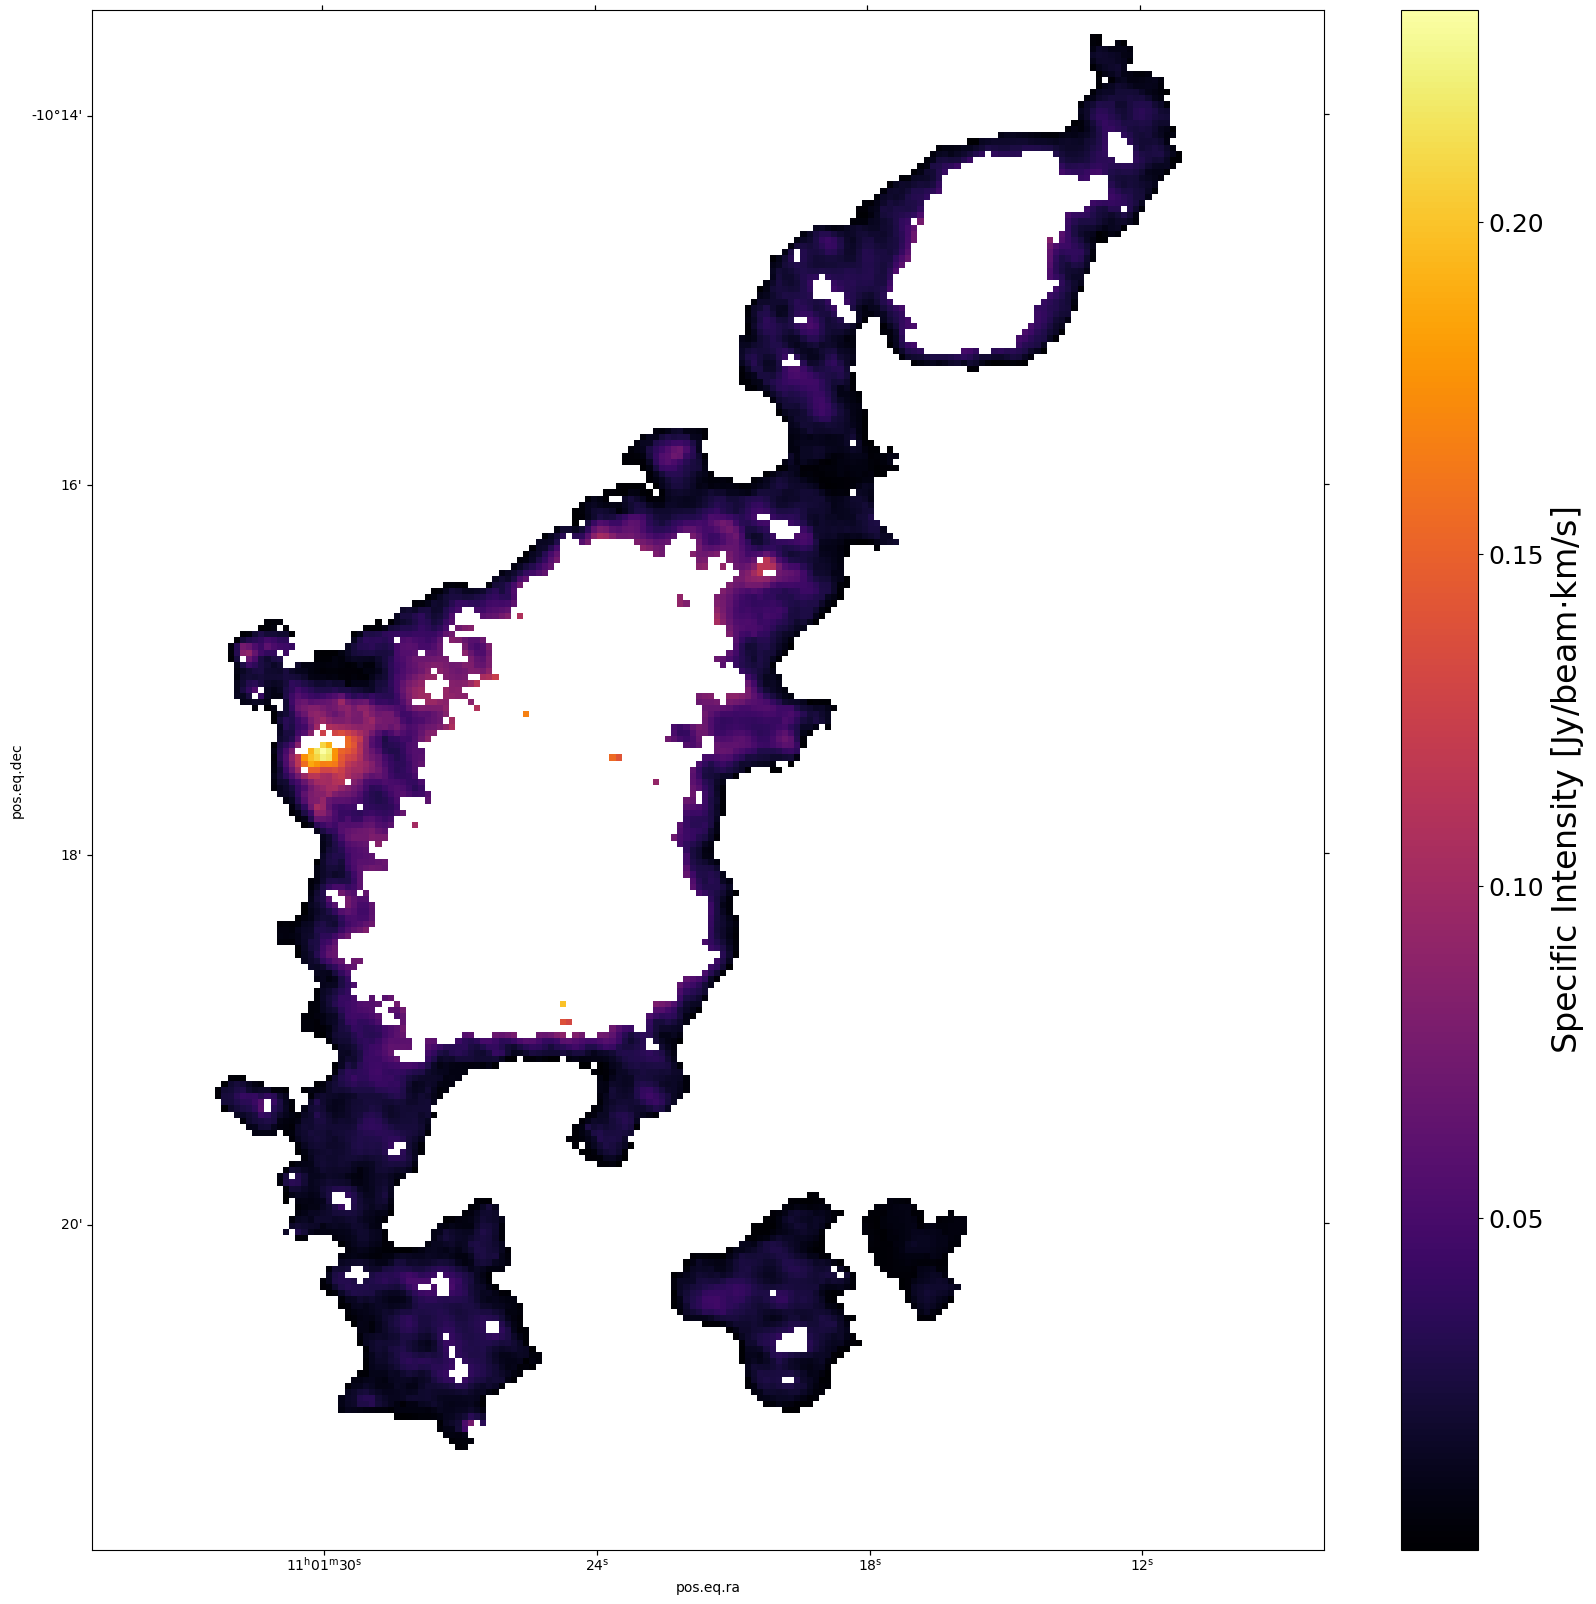

In [7]:
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(projection= WCS(header_mom0))
im = ax.imshow(anom_mom0_copy, cmap = 'inferno')
#ax.contour(S1237_copy, levels=[1.01e-2, 4.74e-2, 8.48e-2, 0.12, 0.16], colors = 'grey')


cbar = plt.colorbar(im)
cbar.set_label(r"Specific Intensity [Jy/beam$\cdot$km/s]", size=24)
#cbar.ax.set_yticklabels(['0.0','', '0.1','', '0.2','', '0.3','', '0.4'])
cbar.ax.tick_params(labelsize=18)
#plt.savefig('mom0_anom.pdf', bbox_inches='tight')

In [141]:
#hdu = fits.PrimaryHDU(cube_copy, header=header_cube)
#hdu.writeto('data/pbcorr_J1059_09_HI.image_S1.gauss_model_disk.fits', overwrite=True)
#hdu = fits.PrimaryHDU(cube_lead, header=header_cube)
#hdu.writeto('data/pbcorr_J1059_09_HI.image_S1.gauss_model_lead2.fits', overwrite=True)
#hdu = fits.PrimaryHDU(cube_follow, header=header_cube)
#hdu.writeto('data/pbcorr_J1059_09_HI.image_S1.gauss_model_follow2.fits', overwrite=True)
#hdu = fits.PrimaryHDU(cube_anom, header=header_cube)
#hdu.writeto('data/pbcorr_J1059_09_HI.image_S1.gauss_model_anom.fits', overwrite=True)
hdu = fits.PrimaryHDU(anom_mom0, header=header_mom0)
hdu.writeto('data/pbcorr_J1059_09_HI.image_mom0_S1237.gauss_model_anom.fits', overwrite=True)